# Support Vector Machines (SVM), Kernels et Synthèse
## Auteur: Nagi El Hachem 

### Generate Gaussian data

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers

from genDeuxLunes import genDeuxLunes

In [2]:
def generate_gaussian_data(N, means, std_deviations, dim = 2):
    """Generate data according to a Gaussian distribution
        
        :param N: size of sample to generate
        :param means: array containing the mean of each gaussian data to generate
        :param std_deviations: array containing the std of each gaussian data to generate
        :param dim:
        
        :returns:
            - X: 2d array containing the x and y coordinates of each sample
            - Y: 1d array containing the labels of each sample (label = {1, -1})
        :rtype: int, float
    """
    
    nb_classes = len(means)
    if len(std_deviations) != nb_classes:
        print('means and std_deviation must have same lentgh')
        return
    
    X = np.empty((dim, N))
    Y = np.empty((N))
    nb_class_data = N // nb_classes
    
    for i in range(nb_classes):
        M = means[i] # * np.ones(nb_classes,)
        S = std_deviations[i] * np.eye(dim)
        i1 = i * nb_class_data
        i2 = i1 + nb_class_data
        X[:, i1:i2] = np.random.multivariate_normal(M, S, nb_class_data).T
        Y[i1:i2] = (i + 1) * np.ones((nb_class_data))
    
    if i2 != N:
        X[:, i2:] = np.random.multivariate_normal(M, S, (N - i2)).T
        Y[i2:] = (i + 1) * np.ones((N - i2))
   
    return X, Y

def plot_data_with_labels(X, Y):
    """Plot data with labels"""
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'grey']
    unique = np.unique(Y)
    if len(X.shape) == 1:
        X = np.array([X]).T
    for i, c in enumerate(unique):
        idx = np.where(Y == c)[0]
        x_sub = X[:, idx]
        if X.shape[1] == 1:
            y = [1] * x_sub.shape[1]
        else:
            y = x_sub[1, :]
        y = x_sub[1, :]
        plt.scatter(x_sub[0, :], y, c = colors[i])
    plt.show()

In [3]:
X, Y = generate_gaussian_data(51, [[2, 2], [5, 5]],[1, 1])

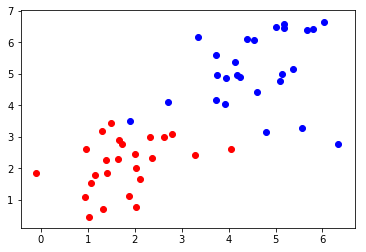

In [4]:
plot_data_with_labels(X, Y)

# 1. Soft Margin SVM

Dans cette partie, on implemente la classe SVM.

### Rappel :
    
- La matrice de Gram G correspond à la matrice carée de dimension N x N, N étant le nombre d'exemples d’apprentissage, définie par :
$$G(i,j) = y_iy_jK(x_i, x_j)$$
- L'entrainement des SVMs consiste à résoudre le problème dual défini par :
$$\begin{align} 
&Maximize: Q(\alpha) = \sum_i\alpha_i − \frac{1}{2}\sum_i\sum_j\alpha_i\alpha_jG(i,j) \\
&Subject\;to: 
\sum_i \alpha_iy_i = 0 \\
&\qquad \qquad \; C \ge \alpha_i \ge 0 \\
\end{align}$$

### kernels

In [5]:
def linear_kernel(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.dot(x, y)

def poly_kernel(x, y, d = 4):
    x = np.array(x)
    y = np.array(y)
    return (np.dot(x, y) + 1) ** d

def rbf_kernel(x, y, sigma = 1):
    x = np.array(x)
    y = np.array(y)
    norm = np.linalg.norm(x - y)
    return np.exp(- (norm ** 2) / (sigma ** 2))

#### SVM

In [6]:
class SVM:
    """
    Attributes:
        weights : 
        bias :
        alphas : lagrange multipliers (if alpha(xi) != 0 -> xi = support vector)
        C : slack penalty (how much we 'll tolerate error)
        gram_matrix : gram matrix, contains the computed inner product (xi.T).xj * yi * yj
            where xi, xj = data samples and yi, yj = data labels
         b = self.labels[self.support_vectors_idx] - self.weights @ (self.data.T)[:, self.support_vectors_idx]
    
        b = np.mean(b, axis=0)
    """
    
    def __init__(self):
        self.kernel = linear_kernel
        self.kernel_args = []
        self.colors = ['red', 'blue', 'green', 'purple', 'orange', 'grey']
        self.cmaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys']
    
    def compute_bias(self, EPSILON = 1e-2):
        self.lagrange_multipliers[self.lagrange_multipliers < EPSILON] = 0
        self.support_vectors_idx = np.where(self.lagrange_multipliers > 0)[0]
        if self.support_vectors_idx.shape[0] == 0:
            return 0
        bias = 0
        for i in self.support_vectors_idx:
            kernels = np.array([self.kernel(self.data[:, j], self.data[:, i], *self.kernel_args)
                            for j in range(self.data.shape[1])])
         
            bias += self.labels[i] - np.sum(self.lagrange_multipliers * self.labels * kernels)
        
        return bias / self.support_vectors_idx.shape[0]
    
    def set_kernel(self, kernel, *args):
        self.kernel = kernel
        self.kernel_args = args
    
    def decision(self, X):
        """
        retourne une liste correspondant la valeur de la fonction de
        décision du SVM entraı̂né sur les éléments contenus dans data
        returns a list of labels of data (preduct labels)
        INPUT: data = (D, N)
        OUTPUT: list(N): distance from boundary
        """
        kernels = np.array([self.kernel(self.data[:, i], X, *self.kernel_args)
                            for i in range(self.data.shape[1])])
        desc = np.sum(self.lagrange_multipliers * self.labels * kernels) + self.bias
        return desc

    
    def process(self, data):
        """
        returns a list of labels of data (preduct labels)
        INPUT: data = (D, N)
        OUTPUT: list(N)
        """
        labels = self.decision(data) # labels here represents the distance from boundary of each sample
        labels[labels <= 0] = -1
        labels[labels > 0] = 1
        return labels
                
    def print_2Ddecision(self, nb_samples=50, print_sv=True, print_non_sv=True, levels=[0., 1.], color='seismic'):
        eps = 0.2
        xmin, ymin = np.min(self.data, axis = 1) - eps
        xmax, ymax = np.max(self.data, axis = 1) + eps
       
        # generate nb_samples floats between xmin, xmax
        x = np.linspace(xmin, xmax, nb_samples)
        y = np.linspace(ymin, ymax, nb_samples)
        x, y = np.meshgrid(x, y) # Generates a grid with x, y values

        nb_classes = len(self.multi_lagrange_multipliers)
        c_z = np.empty(shape=(nb_classes,) + x.shape)
        alpha = 1
        
        for c in range(nb_classes):
            svm.lagrange_multipliers = self.multi_lagrange_multipliers[c]
            svm.labels = self.multi_labels[c]
            svm.bias = self.multi_bias[c]
            
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    c_z[c, i, j] = svm.decision(np.array((x[i, j], y[i, j])))
            
            if nb_classes != 2:
                plt.pcolor(x, y, c_z[c, :, :], cmap=self.cmaps[c], vmin=-1, vmax=1, alpha=alpha)
            elif c == 0:
                plt.pcolor(x, y, c_z[c, :, :], cmap=color, vmin=-1, vmax=1)
            
            if 0. in levels:
                plt.contour(x, y, c_z[c, :, :], levels =[0.], colors='white', alpha=0.5, linewidths=3)
            if 1. in levels:
                plt.contour(x, y, c_z[c, :, :], levels =[1.], colors=self.colors[c], linestyles='dashed', linewidths=1.5)
            if -1. in levels:
                plt.contour(x, y, c_z[c, :, :], levels =[-1.], colors=self.colors[c], linestyles='dashed', linewidths=0.5)
            
            alpha /= 2

        plt.axis([x.min(), x.max(), y.min(), y.max()])
        self.__plot_data(print_sv, print_non_sv)

    def __plot_data(self, print_sv, print_non_sv):
        classes = np.unique(self.labels_all)
        for i, c in enumerate(classes):
            idx = None
            # filter support vector
            lagrange_multipliers = self.multi_lagrange_multipliers[i]
            if print_sv and not print_non_sv:
                idx = np.where(lagrange_multipliers != 0)[0]
            elif not print_sv and print_non_sv:
                idx = np.where(lagrange_multipliers == 0)[0]
            elif not print_sv and not print_non_sv:
                idx = [-1]
            # get class data
            tmp = np.where(self.labels_all == c)[0]
            idx = tmp if idx is None else np.intersect1d(idx, tmp)
            x_sub = self.data[:, idx]
            # scatter filtered data    
            plt.scatter(x_sub[0, :], x_sub[1, :], c = self.colors[i])
    
    def __compute_gram_matrix(self):
        """computes the gram coeffincient for each couple (xi, yi - xj, yj)
        where gram_coef = yi * yj * (xi.T).xj
        where xi, xj = data samples and yi, yj = data labels
        """
        gram_matrix = np.zeros((self.labels.shape[0], self.labels.shape[0]))
        size = self.labels.shape[0]
        for i in range(size):
            for j in range(size):
                gram_matrix[i,j] = self.labels[i] * self.labels[j] \
                    * self.kernel(self.data[:, i], self.data[:, j], *self.kernel_args)
        return gram_matrix
    
    def __compute_lagrange_multipliers(self):
        """
        http://cvxopt.org/userguide/coneprog.html
        P -- (N, N) = matrice de gram
        q -- (N,)   = vecteur rempli de -1 
        G -- (N,N)  = - matrice identité de taille n
        b -- (1,)   = vecteur nul
        A -- (,N)   = vecteur ligne qui contient les labels (yi)
        h -- (N,)   = vecteur avec que de 0
        """
        
        # Setup solver inputs
        data_size = self.labels.shape[0]
        P = matrix(self.gram_matrix, tc='d') # d means floats
        q = matrix(np.full(self.labels.shape, -1, dtype=float), tc='d')
        G = matrix(-np.identity(data_size), tc='d') if self.C is None \
            else matrix(np.concatenate((-np.identity(data_size), np.identity(data_size))), tc='d')
        b = matrix(np.zeros(1), tc='d')
        A = matrix(self.labels, tc='d').T
        h = matrix(np.zeros(data_size), tc='d') if self.C is None \
            else matrix(np.concatenate((np.zeros(data_size), self.C * np.ones(data_size))), tc='d')   
        solvers.options['show_progress'] = self.show_progress
        solution = solvers.qp(P, q, G, h, A, b)['x'] # Get oprtimal values
        return np.asarray(solution).reshape((data_size,)) # Convert matrix to numpy array
    
    def __train(self, data, labels):
        """ find the separator coordinates
        Args:
            data: (D, N), D = dimension, N = nbr samples
            labels: (N,), N ∈ {1, -1}
        """ 
        
        self.data, self.labels = data, labels
        self.gram_matrix = self.__compute_gram_matrix()
        self.lagrange_multipliers = self.__compute_lagrange_multipliers()

        self.bias = self.compute_bias()
        
    def train(self, data, labels, C = None, show_progress = False):
        self.C = C
        self.show_progress = show_progress
        classes = np.unique(labels)
        Y = np.empty(shape=labels.shape)
        nb_classes = classes.shape[0]
        self.multi_lagrange_multipliers = [None] * nb_classes
        self.multi_bias = [None] * nb_classes
        self.multi_labels = [None] * (nb_classes)
        self.labels_all = labels
        for i, c in enumerate(classes):
            Y[:] = -1
            idx = np.where(labels == c)[0]
            Y[idx] = 1
            self.__train(data, Y)
            self.multi_lagrange_multipliers[i] = svm.lagrange_multipliers.copy()
            self.multi_labels[i] = Y.copy()
            self.multi_bias[i] = self.bias

## 1.1 Very Tiny Toy
On va Testez l'algorithme sur le dataset suivant:

| value | label |
|-------|-------|
|   1   |   -1  |
|   2   |   +1  |
|   3   |   +1  |

- Observer le nombre de vecteurs de supports sur cet exemple, ainsi que la valeur du coefficient de Lagrange associé à chaque vecteur de support.
- Ces valeurs vous semblent elles cohérentes?

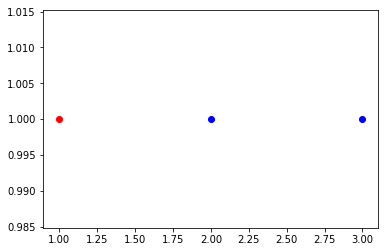

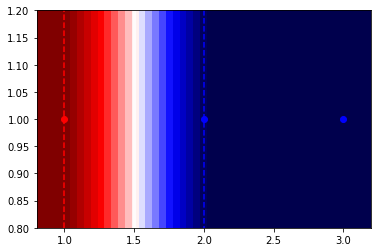

In [52]:
X = np.array([[1.,2.,3.], [1., 1., 1.]])
Y = np.array([-1.,1.,1.])
plot_data_with_labels(X, Y)
data, labels = X, Y
svm = SVM()
svm.train(data, labels)
svm.print_2Ddecision()

## 1.2 2D Tiny Toy

Dans cette partie, on testera notre SVM sur un dataset un peu plus complexe.
- On remarquera les limites du Kernel Linéaire avec l'example des données en XOR.
- Pour bien comprendre le kernel polynomial, on testera notre SVM sur les données deuxLunes.
- On s'ammusera aussi à tester notre SVM sur les données circle, donuts et spiral

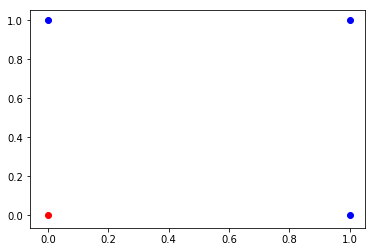

In [75]:
X = np.array([[0., 0., 1., 1.], [0., 1., 0., 1.]])
Y = np.array([-1.,1.,1.,1.])
plot_data_with_labels(X, Y)
data, labels = X, Y

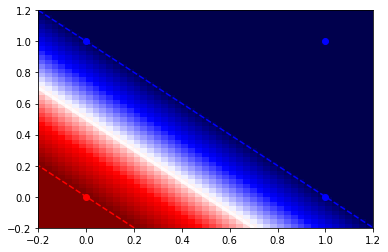

In [78]:
svm = SVM()
svm.train(data, labels)
svm.print_2Ddecision()

### XOR 
Avec un svm linéaire, on n'arrive pas à séparer les données. Pour les séparer, on utilise un kernel polynomial d'ordre 2

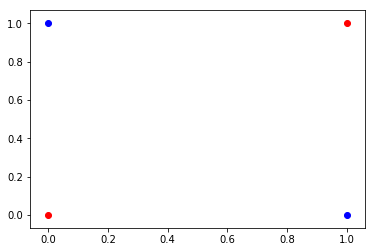

In [55]:
X = np.array([[0.,0.,1.,1.], [0.,1.,0.,1.]])
Y = np.array([-1.,1.,1.,-1.])
plot_data_with_labels(X, Y)
data, labels = X, Y

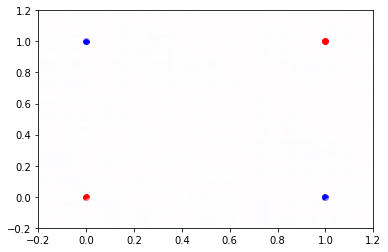

In [56]:
svm = SVM()
svm.train(data, labels)
svm.print_2Ddecision()

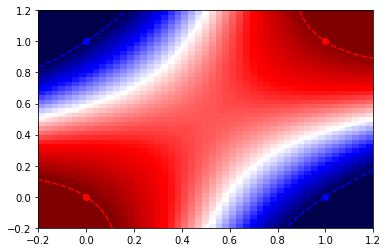

In [57]:
svm.set_kernel(poly_kernel, 2)
svm.train(data, labels)
svm.print_2Ddecision()

### 2 lunes

In [58]:
dist = 1
n = 100

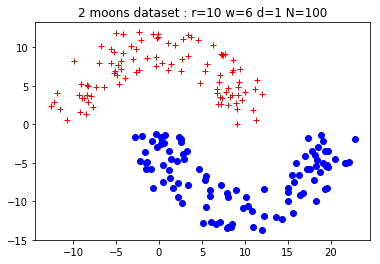

In [59]:
X, Y = genDeuxLunes(dist, n)
data, labels = np.array(X), np.array(Y)
idx_1 = np.where(labels == 1)[0]
idx_2 = np.where(labels == -1)[0]
labels[idx_1] = -1
labels[idx_2] = 1

In [60]:
svm = SVM()
svm.set_kernel(poly_kernel, 2)
svm.train(data, labels)

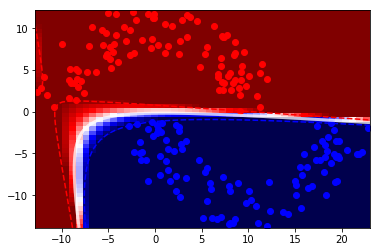

In [61]:
svm.print_2Ddecision()

In [62]:
svm.set_kernel(rbf_kernel, 20)
svm.train(data, labels)

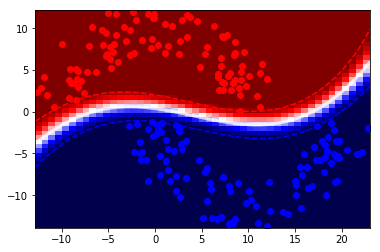

In [63]:
svm.print_2Ddecision()

### Données Circulaires et bruités
Avec un dataset bruité, le hard-margin svm n'arrive pas à trouver le séparateur linéaire entre les 2 classes. En effet, l'optimiseur ne trouve pas de solution. Pour remédier à ça, on a recourt au soft-margin svm. Il faut bien choisir l'hyper-parametre $C$

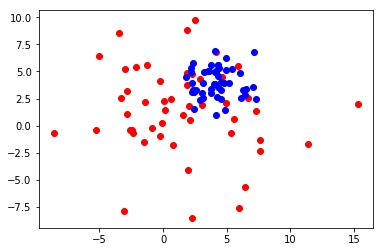

In [81]:
# générer des données bruitées 
X, Y = generate_gaussian_data(100, [[1, 1], [4, 4]], [15, 2])
plot_data_with_labels(X, Y)
data, labels = X, Y

In [82]:
svm = SVM()
svm.set_kernel(poly_kernel, 2)
svm.train(data, labels, C=10)

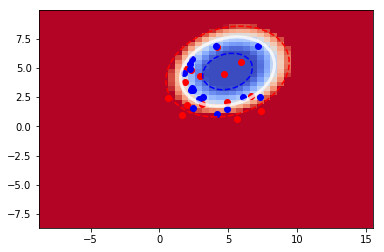

In [83]:
svm.print_2Ddecision(print_non_sv=False, color='coolwarm')

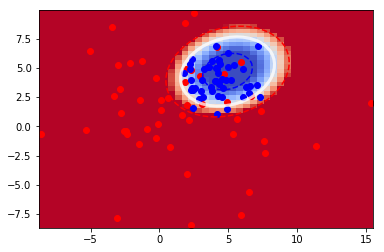

In [85]:
svm.print_2Ddecision(color='coolwarm')

### MultiClass Management
Par définition, un svm recherche la meilleure marge qui sépare deux classes. Que faire quand on a plus que deux classes dans notre dataset ? 

Il y a plusieures manière de procéder. Dans notre cas, nous avons choisis la méthode one-versus-rest dans laquelle on entraine un svm par classe. En effet, pour chaque classe on considère toutes les autres classes comme une seule classe géante et le SVM cherche la meilleure marge qui sépare la classe principale de toutes les autres classes.

Dans cette partie, on testera notre implementation du SVM sur un probleme de classification plusieurs classes

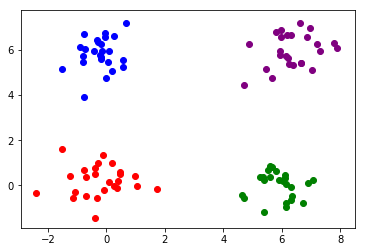

In [68]:
X, Y = generate_gaussian_data(100, [[0, 0], [0, 6], [6, 0],  [6, 6]], [0.5, 0.5, 0.5, 0.5])
plot_data_with_labels(X, Y)

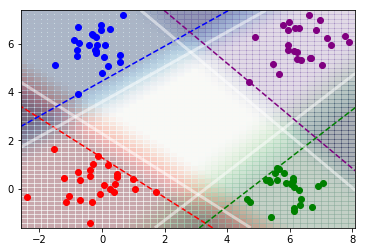

In [69]:
svm = SVM()
svm.train(X, Y)
svm.print_2Ddecision()

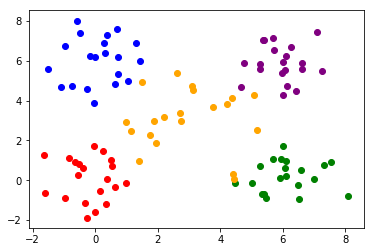

In [24]:
X, Y = generate_gaussian_data(100, [[0, 0], [0, 6], [6, 0],  [6, 6], [3, 3]], [1, 1, 1, 1, 2.5])
plot_data_with_labels(X, Y)

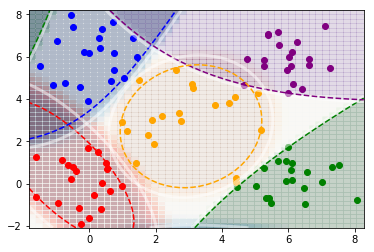

In [25]:
svm = SVM()
svm.set_kernel(poly_kernel, 2)
svm.train(X, Y, C = 3)
svm.print_2Ddecision()

In [26]:
svm.set_kernel(rbf_kernel, 10)
svm.train(X, Y, C = 3)

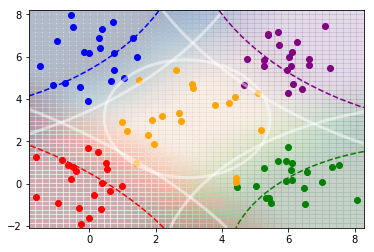

In [27]:
svm.print_2Ddecision(levels = [0., 1.])

In [86]:
mon_fichier = open("donuts.txt", "r")
mon_fichier
data_x = []
data_y = []
for line in mon_fichier.readlines():
    line = line.strip()
    doc = line.split(" ")

    data_y.append(float(doc[2]))
    data_x.append((float(doc[0]), float(doc[1])))

In [87]:
X = np.array(data_x).T
Y = np.array(data_y)

In [88]:
svm.set_kernel(rbf_kernel, 0.1)
svm.train(X, Y, C = 3)

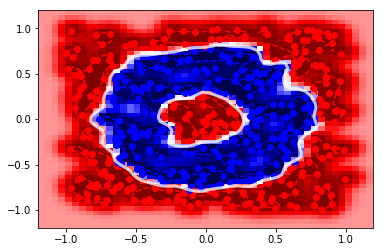

In [73]:
svm.print_2Ddecision(levels = [0., 1.])

# Test

Quelques tests pour bien comprendre les différents kernels du svm  

In [7]:
x = [-0.75, -0.58, -0.44, -0.42, -0.09, 0, 0.18, 0.24, 0.65, 0.81]
y = [-0.8, -0.58, 0.11, 0.78, -0.35, -0.68, 0.4, 0.03, 0.72, -0.45]
X = np.array([x, y])
Y = np.array([1., -1., -1., -1., -1., 1., -1, 1., 1., 1.])

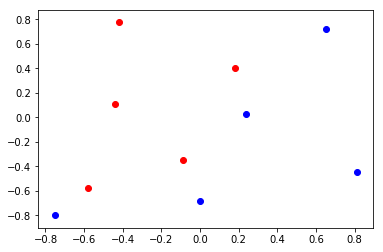

In [11]:
plot_data_with_labels(X, Y)

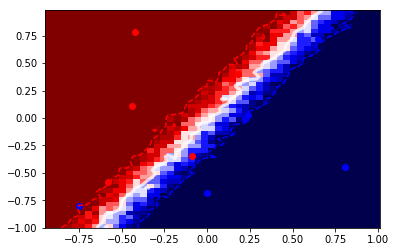

In [19]:
svm = SVM()
svm.set_kernel(rbf_kernel, 1e6)
svm.train(X, Y, C=1e15)
svm.print_2Ddecision()

In [10]:
X1 = 10 * X

array([[-7.5, -5.8, -4.4, -4.2, -0.9,  0. ,  1.8,  2.4,  6.5,  8.1],
       [-8. , -5.8,  1.1,  7.8, -3.5, -6.8,  4. ,  0.3,  7.2, -4.5]])

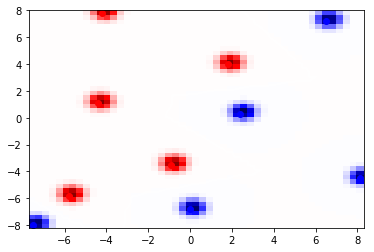

In [13]:
svm = SVM()
svm.set_kernel(rbf_kernel, 0.5)
svm.train(X1, Y, C=1e15)
svm.print_2Ddecision()